# Preliminaries

In [53]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator

from sklearn.cluster import *

%matplotlib inline

plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [54]:
#Load ESCAPE training data
escapeAllData = pd.read_csv("Data/Original DataFrames/AllDataSingleValue.csv", sep=",", index_col='DEIDNUM').sort_index() #all feature dataset
escapeHemo = pd.read_csv("Data/Original DataFrames/HemoSingleValue.csv", sep=",", index_col='DEIDNUM').sort_index() #dataset with only hemodynamics
escapeLabels  = pd.read_csv("Data/Original DataFrames/Labels.csv", sep=",", index_col='DEIDNUM').sort_index() #labels for prediction classes 

#Cardiogenic Shock
cardShockHemo = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/HemoCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockAllData = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/AllDataCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockHemoLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/HemoLabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()
cardShockLabels = pd.read_csv("Data Validation/Cardiogenic Shock/Original DataFrames/LabelsCardiogenicShock.csv", sep=",", index_col='ID').sort_index()

#Serial Cardiac
serialHemo = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/HemoSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialAllData = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/AllDataSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialHemoLabels = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/HemoLabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()
serialLabels = pd.read_csv("Data Validation/Serial Cardiac Caths/Original DataFrames/LabelsSerialCardiac.csv", sep=",", index_col='ID').sort_index()

#BEST
bestAllData = pd.read_csv("Data Validation/BEST/Original DataFrames/AllDataBEST.csv", sep=",", index_col='ID').sort_index()
bestLabels = pd.read_csv("Data Validation/BEST/Original DataFrames/LabelsBEST.csv", sep=",", index_col='ID').sort_index()

#Guide it
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/AllDataGUIDE-IT.csv", sep=",", index_col='ID').sort_index()
guideLabels = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/LabelsGUIDE-IT.csv", sep=",", index_col='ID').sort_index()


# Global Params

In [55]:
# Global Flags
pcaFlag = True
fitPredFlag = True

# Choose clutering model
# clusterModel = KMeans(n_clusters=5) #pred, PCA
clusterModel = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward') #fitPred, PCA
# clusterModel = SpectralClustering(n_clusters=5, assign_labels='discretize') #fitPred, PCA
# clusterModel = Birch(n_clusters=5) #basically mini batch kmeans, pred, PCA

hemoModelName = 'Cluster_Hemo'
allDataModelName = 'Cluster_AllData'

# Group All Data Together

## HEMO

In [111]:
hemoOrig = escapeHemo.append(cardShockHemo)
hemoOrig = hemoOrig.append(serialHemo)
hemoOrig.index.name = 'ID'
hemoOrig

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,PP,PPP,PAPP,SVR,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat
ID,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,28.0,0.245614,0.428571,5357.575758,0.666667,0.266667,0.750000,0.777778,50.0,1.166667
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,24.0,0.235294,0.428571,3509.677419,0.750000,0.272727,1.000000,1.000000,50.0,1.333333
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,17.0,0.212500,0.500000,1982.300885,0.555556,0.242857,2.000000,0.944444,45.0,1.700000
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,40.0,0.470588,0.571429,1772.043011,0.705882,0.571429,1.666667,2.352941,45.0,3.333333
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,34.0,0.354167,0.627451,2621.138211,0.166667,0.566667,10.666667,1.888889,44.0,11.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z958018,55.0,2.0,NaN,NaN,20.0,45.0,20.0,29.0,20.0,1.97,...,45.0,0.412844,0.555556,5346.869712,1.000000,0.450000,1.250000,2.250000,44.0,2.250000
Z958018,55.0,2.0,NaN,NaN,6.0,43.0,19.0,30.0,20.0,3.20,...,45.0,0.412844,0.558140,3641.666667,0.300000,0.542169,4.000000,2.250000,44.0,7.500000
Z958018,55.0,2.0,NaN,NaN,12.0,47.0,26.0,35.0,32.0,0.93,...,45.0,0.412844,0.446809,12014.336918,0.375000,0.450000,1.750000,1.406250,32.0,3.750000


In [112]:
lst = []

for idx in hemoOrig.index:
    
    if idx in escapeLabels.index:
        row = escapeLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    elif idx in cardShockHemoLabels.index:
        row = cardShockHemoLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    else: #serial hemo
        row = serialHemoLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
        
hemoLabels = pd.DataFrame(lst, columns=['ID','Death', 'Rehosp', 'Readmission']).set_index('ID', drop=True)
hemoLabels

,Death,Rehosp,Readmission
ID,,,
72,1,1,0.0
72,1,1,0.0
81,0,1,0.0
81,0,1,0.0
814,0,0,0.0
...,...,...,...
Z958018,0,1,NaN
Z958018,0,1,NaN
Z958018,0,1,NaN


In [ ]:
# TODO possibly del this --> add labels to clustering ...
hemoOrig['Deth'] = hemoLabels['Death']
hemoOrig['Rhp'] = hemoLabels['Rehosp']
hemoOrig['Rdm'] = hemoLabels['Readmission']

## All Data

In [ ]:
allDataOrig = escapeAllData.append(cardShockAllData)
allDataOrig = allDataOrig.append(serialAllData)
allDataOrig = allDataOrig.append(bestAllData)
allDataOrig = allDataOrig.append(guideAllData)

allDataOrig.index.name = 'ID'
allDataOrig

In [ ]:
lst = []

for idx in allDataOrig.index:
    
    if idx in escapeLabels.index:
        row = escapeLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    elif idx in cardShockLabels.index:
        row = cardShockLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    elif idx in serialLabels.index:
        row = serialLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    elif idx in bestLabels.index:
        row = bestLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
    else: #guide
        row = guideLabels.loc[idx].tolist()
        row.insert(0, idx)
        lst.append(row)
        
allDataLabels = pd.DataFrame(lst, columns=['ID','Death', 'Rehosp', 'Readmission']).set_index('ID', drop=True)
allDataLabels

In [ ]:
# TODO possibly del this --> add labels to clustering ...
allDataOrig['Deth'] = allDataLabels['Death']
# allDataOrig['Rhp'] = allDataLabels['Rehosp']

# Cluster Labels

In [ ]:
#HELPER METHODS
def clusterFindK(X): #find optimal num k
    sum_of_squared_distances = []
    silhouette = []
    K = range(1,16)
    for k in K:
        k_means = KMeans(n_clusters=k, init='k-means++',n_init=50, max_iter=500, tol=1e-04, random_state=0)
        model = k_means.fit(X)
        sum_of_squared_distances.append(k_means.inertia_)
        if k != 1:
            silhouette.append(silhouette_score(X, k_means.labels_))
        
    plt.figure(figsize=(12,7))
    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('K Number of Clusters')
    plt.ylabel('Sum of Squared Error')
    plt.title('Elbow Method to Find Optimal K')
    plt.show()
    
    kl = KneeLocator(K, sum_of_squared_distances, curve="convex", direction="decreasing")
    print("Using the elbow method, the optimal number of clusters is", kl.elbow)
    
    plt.figure(figsize=(12,7))
    plt.plot(range(2,16), silhouette)
    plt.xlabel("K Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()
    
    print("Using Silhouette Scores, the optimal number of clusters is", silhouette.index(max(silhouette))+2)

def plotPCAClusters(X, y_km, K, name): #plot clusters from pca
    df = pd.DataFrame(X, columns=["Component_1", "Component_2"])
    df['Cluster'] = y_km + 1
    plt.figure(figsize=(16,7))
    plt.rcParams.update({'font.size': 18})
    sns.scatterplot(x='Component_1', y='Component_2', hue='Cluster', palette=sns.color_palette('hls', K), data=df, legend='full')
    plt.title("Resulting Score Clusters")
    plt.savefig("Score Label Preprocessing/Figures/Score_Clusters_" + name + ".png")

    plt.show()
    
    return X

def plotClusters(X, y_km, columns, K): #plot original data clusters
    X['cluster'] = y_km + 1
    plt.figure(figsize=(16,7))
    plt.rcParams.update({'font.size': 18})
    sns.scatterplot(x=columns[0], y=columns[1], hue='cluster',palette=sns.color_palette('hls', K), data=X, legend='full')
    plt.show()
    
    return X

def compareClusters(dt, K): #compare details of clusters
    clusters = []
    clusterDesc = []
    for num in range(K):
        cls = dt[dt['cluster'] == num]
        clusters.append(cls)

#         print("Cluster ", num)
#         print(cls.describe())
        clusterDesc.append(cls.describe())
        
    return clusters, clusterDesc

def runClustering(clusterModel, data, origData, labels, modelName, columns, pca=False):
    #Run clustering
    y_model = clusterModel.fit_predict(data)

    #Save cluster model
    pickle.dump(clusterModel, open('Score Label Preprocessing/ClusterModels/' + modelName + '.sav', 'wb'))
    
    #Plot Clusters
    if not pca:
        plotClusters(origData, y_model, columns, 5)
    else:
        plotPCAClusters(data, y_model, 5, modelName)
    
    
    #Get real data with clusters
    DF = copy.deepcopy(origData)
    DF['cluster'] = y_model

    #add class labels
    DF['Death'] = labels['Death']
    DF['Rehosp'] = labels['Rehosp']
    DF['Readmission'] = labels['Readmission']

    #get descriptions of each cluster
    clusters, clusterDesc = compareClusters(DF, 5)
#     print("clusters", clusters)
#     print("cluster desc", clusterDesc)
    
    #get descriptive summary details for each cluster
    descSummary = pd.DataFrame()
    for i in range(len(clusterDesc)):
        descSummary = descSummary.append(clusterDesc[i])
    
    return DF, descSummary, clusters, clusterDesc

def getClusterStats(clusters, clusterDesc):
    i = 0
    for cl in clusterDesc:
        print("Cluster ", i)
        display(cl)
        
        i+= 1
        
#compare distributions of clusters
def distPlotsForClusters(cls, cols, name):
    clusters = copy.deepcopy(cls)
    for c in cols:
        f, ax = plt.subplots(figsize=(11,9))
        for i in range(len(clusters)):
            currCls = pd.DataFrame(clusters[i])
            currCls = currCls.replace(np.inf, 0)
            sns.distplot(currCls[c], ax=ax, label=i)
        
        plt.title(c+ ' Distribution by Cluster')
        plt.ylabel("Distribution Value")
        plt.legend(title="Cluster")
        
        plt.savefig("Score Label Preprocessing/Figures/" + name + "/Clusters"+c+".png")

def assignScoresFromClusters(descSummary):
    clsScDF = pd.DataFrame()
    clsScDF.index.name = 'Cluster'

    scores = [1,2,3,4,5]
    dthMn = descSummary.loc['mean']['Death'].to_numpy()
    rehospMn = descSummary.loc['mean']['Rehosp'].to_numpy()
    readmMn = descSummary.loc['mean']['Readmission'].to_numpy()
    
    dthScores = [0,0,0,0,0]
    cnt = 0
    for v in np.argsort(dthMn):
        dthScores[v] = scores[cnt]
        cnt += 1

    rehospScores = [0,0,0,0,0]
    cnt = 0
    for v in np.argsort(rehospMn):
        rehospScores[v] = scores[cnt]
        cnt += 1

    readmScores = [0,0,0,0,0]
    cnt = 0
    for v in np.argsort(readmMn):
        readmScores[v] = scores[cnt]
        cnt += 1

    clsScDF['DeathMean'] = dthMn
    clsScDF['DeathScores'] = dthScores
    clsScDF['RehospMean'] = rehospMn
    clsScDF['RehospScores'] = rehospScores
    clsScDF['ReadmMean'] = readmMn
    clsScDF['ReadmScores'] = readmScores

    aveScores = []
    for i in clsScDF.index:
        c = clsScDF.loc[i]
        a = c['DeathScores'] + c['RehospScores'] + c['ReadmScores']
        aveScores.append(a/3)

    clsScDF['AveScores'] = aveScores
    
    rankIndex = sorted(range(len(aveScores)), key = lambda sub: aveScores[sub], reverse=True)[:5] 
    print("rank index", rankIndex)
    finalScores = [0,0,0,0,0]
    val = 5
    for r in rankIndex:
        finalScores[int(r)] = val
        val -= 1
    
    return clsScDF, finalScores
    

def saveClusteredData(hemoDF, scoreAsmts, saveName):
    
    clusNums = hemoDF['cluster']

    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['FinalScores']))
    hemoDF['Score'] = labels

    #Death Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['DeathScores']))
    hemoDF['ScoreDeath'] = labels

    #Rehosp Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['RehospScores']))

    hemoDF['ScoreRehosp'] = labels

    #Readm Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['ReadmScores']))
    hemoDF['ScoreReadmission'] = labels

    hemoDF = hemoDF.drop(columns=["cluster"])
    hemoDF = hemoDF.drop(columns=["Death"])
    hemoDF = hemoDF.drop(columns=["Rehosp"])
    hemoDF = hemoDF.drop(columns=["Readmission"])

    hemoDF.to_csv(saveName)
    
    return hemoDF

# Cluster Hemodynamic

In [ ]:
# first - try other clustering methods
hemo = copy.deepcopy(hemoOrig)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

if pcaFlag:
    scaler = MinMaxScaler()#scale data
    hemo.loc[:,:] = scaler.fit_transform(hemo)
    pca = PCA(n_components=2)
    data = pca.fit_transform(hemo)
else:
    data=hemo

In [ ]:
#Explain PCA Components

# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
print(most_important)

initial_feature_names = hemo.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())
df

In [ ]:
# Find optimal K
clusterFindK(data)

In [ ]:
# Do clustering using optimal k
hemoDF, descSummary, clusters, clusterDesc = runClustering(clusterModel=clusterModel, data=data, origData=hemoOrig, labels=hemoLabels, 
                                    modelName=hemoModelName, columns=['Gender', 'CPI'], pca=pcaFlag)
hemoDF

In [ ]:
# Assign final scores
scoreAsmts, finalScores = assignScoresFromClusters(descSummary)
scoreAsmts

In [ ]:
print(finalScores)
scoreAsmts['FinalScores'] = finalScores
scoreAsmts

In [ ]:
# Look at stats of each cluster
getClusterStats(clusters, clusterDesc)

In [ ]:
colss = ['Age', 'Gender', 'Race', 'EjF', 'RAP', 'PAS', 'PAD', 'PAMN', 'PCWP', 'CO',
       'CI', 'MIXED', 'BPSYS', 'BPDIAS', 'HRTRT',  'MAP',
       'MPAP', 'CPI', 'PP', 'PPP', 'PAPP', 'SVR', 'RAT', 'PPRatio', 'PAPi', 'SAPi', 'CPP',
       'PRAPRat']

distPlotsForClusters(cls=clusters, cols=colss, name="Hemo")

In [ ]:
colss= ['Death', 'Rehosp', 'Readmission']
distPlotsForClusters(cls=clusters, cols=colss, name="Hemo")

In [ ]:
#Save separate datasets
escIndx = sorted(list(set(escapeHemo.index)))
escH = hemoDF.loc[escIndx,:]

escH = saveClusteredData(escH, scoreAsmts,"Data/Preprocessed Data/ESCAPE_Hemo.csv")
escH

In [ ]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(escH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [ ]:
shockIndx = sorted(list(set(cardShockHemo.index)))
csH = hemoDF.loc[shockIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_Hemo.csv")
csH

In [ ]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(csH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [ ]:
serialIndx = sorted(list(set(serialHemo.index)))
csH = hemoDF.loc[serialIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_Hemo.csv")
csH

In [ ]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(csH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

# ALL DATA

In [ ]:
# first - try other clustering methods
allD = copy.deepcopy(allDataOrig)
allData = allD.replace(np.inf, 0)
allData = allData.fillna(0)

if pcaFlag:
    scaler = MinMaxScaler()#scale data
    allData.loc[:,:] = scaler.fit_transform(allData)
    pca = PCA(n_components=2)
    data = pca.fit_transform(allData)
else:
    data=allData

In [ ]:
#Explain PCA Components

# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
print(most_important)

initial_feature_names = allData.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())
df

In [ ]:
# Find optimal K
clusterFindK(data)

In [ ]:
# Cluster using best k
allDataDF, descSummary, clusters, clusterDesc  = runClustering(clusterModel=clusterModel, data=data, origData=allDataOrig, labels=allDataLabels, 
                                    modelName=allDataModelName, columns=['MAP', 'BPDIAS'], pca=pcaFlag)
allDataDF

In [ ]:
# Look at stats of each cluster
getClusterStats(clusters, clusterDesc)

In [ ]:
colss = ['Age', 'Gender', 'Race', 'Wt', 'BMI', 'InitialHospDays',
       'TotalHospDays', 'NYHA', 'MLHFS', 'AF', 'AlchE', 'ANGP', 'ARRH',
       'CARREST', 'CVD', 'COPD', 'DEPR', 'DIAB', 'GOUT', 'HEPT', 'HTN',
       'MALIG', 'RENAL', 'SMOKING', 'STERD', 'StrokeTIA', 'VAHD', 'VF', 'VHD',
       'VT', 'ISCH', 'NonISCH', 'CABG', 'HTRANS', 'ICD', 'PACE', 'PTCI',
       'SixFtWlk', 'VO2', 'ALB', 'ALT', 'AST', 'BUN', 'CRT', 'DIAL', 'HEC',
       'HEM', 'PLA', 'POT', 'SOD', 'TALB', 'TOTP', 'WBC', 'ACE', 'BET', 'NIT',
       'DIUR', 'EjF', 'BPDIAS', 'BPSYS', 'HR', 'PV', 'MAP', 'PP', 'PPP',
       'PPRatio']

distPlotsForClusters(cls=clusters, cols=colss, name="All Data")

In [ ]:
colss= ['Death', 'Rehosp', 'Readmission']
distPlotsForClusters(cls=clusters, cols=colss, name="All Data")

In [100]:
scoreAsmts, finalScores = assignScoresFromClusters(descSummary)
scoreAsmts

rank index [3, 2, 4, 0, 1]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
Cluster,,,,,,,
0,0.257418,1,0.561347,2,0.187354,5,2.666667
1,0.567057,5,0.473447,1,0.000000,1,2.333333
2,0.302326,2,0.647743,4,0.125000,4,3.333333
3,0.340611,4,0.657205,5,0.000000,2,3.666667
4,0.337321,3,0.606858,3,0.000000,3,3.000000


In [101]:
print(finalScores)
scoreAsmts['FinalScores'] = finalScores
scoreAsmts

[2, 1, 4, 5, 3]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
Cluster,,,,,,,,
0,0.257418,1,0.561347,2,0.187354,5,2.666667,2
1,0.567057,5,0.473447,1,0.000000,1,2.333333,1
2,0.302326,2,0.647743,4,0.125000,4,3.333333,4
3,0.340611,4,0.657205,5,0.000000,2,3.666667,5
4,0.337321,3,0.606858,3,0.000000,3,3.000000,3


In [28]:
#Save separate datasets
escIndx = sorted(list(set(escapeAllData.index)))
escH = allDataDF.loc[escIndx,:]

escH = saveClusteredData(escH, scoreAsmts,"Data/Preprocessed Data/ESCAPE_AllData.csv")
escH

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,MAP,PP,PPP,PPRatio,Deth,Rhp,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
72.0,88.0,2.0,1.0,57.100000,26.424175,9.0,16.0,4.0,76.0,1.0,...,139.333333,26.0,0.276596,0.250000,1,1,3,1,3,5
72.0,88.0,2.0,1.0,52.000000,24.064047,9.0,16.0,3.0,76.0,1.0,...,126.000000,26.0,0.302326,0.282609,1,1,3,1,3,5
72.0,37.0,2.0,2.0,64.863709,0.000000,0.0,0.0,3.0,0.0,1.0,...,118.000000,28.0,0.341463,0.411765,1,1,2,3,2,3
81.0,69.0,1.0,1.0,102.363636,32.307675,5.0,13.0,4.0,21.0,1.0,...,125.333333,32.0,0.363636,0.457143,0,1,3,1,3,5
81.0,69.0,1.0,1.0,100.454545,31.705134,5.0,13.0,2.0,21.0,1.0,...,105.666667,34.0,0.441558,0.472222,0,1,3,1,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99302.0,41.0,1.0,2.0,97.400000,40.541103,21.0,21.0,NaN,79.0,0.0,...,130.000000,55.0,0.550000,0.733333,1,1,3,1,3,5
99912.0,46.0,1.0,1.0,78.636364,25.677180,2.0,2.0,4.0,89.0,0.0,...,174.666667,38.0,0.316667,0.567164,0,0,3,1,3,5
99912.0,46.0,1.0,1.0,78.200000,25.534694,2.0,2.0,3.0,89.0,0.0,...,140.666667,24.0,0.255319,0.400000,0,0,3,1,3,5


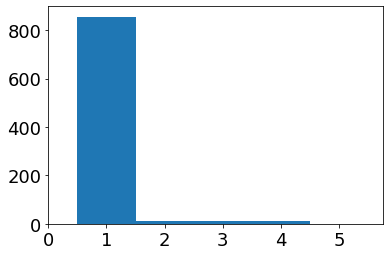

In [29]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(escH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [30]:
guIndx = sorted(list(set(guideAllData.index)))
guH = allDataDF.loc[guIndx,:]

guH = saveClusteredData(guH, scoreAsmts,"Data Validation/GUIDE-IT/Preprocessed Data/GUIDE-IT_AllData.csv")
guH

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,MAP,PP,PPP,PPRatio,Deth,Rhp,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
11.0,77.0,1.0,1.0,74.389149,0.000000,0.0,0.0,3.0,0.0,1.0,...,165.333333,52.0,0.433333,0.812500,0,1,5,2,5,4
11.0,57.0,2.0,2.0,88.905017,33.643189,0.0,70.0,3.0,0.0,0.0,...,148.000000,33.0,0.323529,0.375000,0,1,3,1,3,5
11.0,57.0,2.0,2.0,91.172066,0.000000,0.0,70.0,3.0,0.0,0.0,...,147.000000,32.0,0.316832,0.363636,0,1,3,1,3,5
615.0,59.0,1.0,1.0,75.296333,0.000000,0.0,0.0,3.0,0.0,0.0,...,169.333333,36.0,0.310345,0.375000,0,1,2,3,2,3
615.0,70.0,2.0,2.0,87.500000,34.179688,0.0,0.0,3.0,0.0,0.0,...,184.000000,54.0,0.409091,0.600000,0,1,3,1,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98788.0,56.0,1.0,2.0,NaN,0.000000,0.0,3.0,NaN,0.0,1.0,...,NaN,NaN,NaN,NaN,0,1,4,4,4,2
99329.0,33.0,1.0,2.0,142.400000,52.241316,0.0,30.0,3.0,0.0,0.0,...,135.333333,32.0,0.340426,0.400000,0,1,3,1,3,5
99329.0,33.0,1.0,2.0,NaN,0.000000,0.0,30.0,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,0,1,4,4,4,2


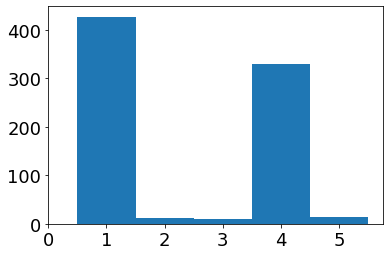

In [31]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(guH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [32]:
guIndx = sorted(list(set(bestAllData.index)))
guH = allDataDF.loc[guIndx,:]

guH = saveClusteredData(guH, scoreAsmts,"Data Validation/BEST/Preprocessed Data/BEST_AllData.csv")
guH

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,MAP,PP,PPP,PPRatio,Deth,Rhp,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
1.0,73.0,2.0,1.0,50.348753,0.0,0.0,0.0,3.0,0.0,0.0,...,176.666667,60.0,0.461538,0.882353,0,1,2,3,2,3
2.0,72.0,1.0,1.0,77.110703,0.0,0.0,0.0,3.0,0.0,1.0,...,181.666667,40.0,0.320000,0.571429,0,1,5,2,5,4
3.0,58.0,1.0,1.0,94.800805,0.0,0.0,0.0,3.0,0.0,0.0,...,172.666667,36.0,0.305085,0.375000,0,0,5,2,5,4
4.0,42.0,1.0,1.0,134.716934,0.0,0.0,0.0,3.0,0.0,0.0,...,201.666667,35.0,0.259259,0.555556,0,1,5,2,5,4
5.0,58.0,1.0,2.0,70.306817,0.0,0.0,0.0,4.0,0.0,0.0,...,180.333333,62.0,0.466165,0.873239,1,1,5,2,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704.0,60.0,1.0,1.0,86.182550,0.0,0.0,0.0,3.0,0.0,0.0,...,133.333333,25.0,0.277778,0.403226,0,1,5,2,5,4
2705.0,67.0,1.0,1.0,77.110703,0.0,0.0,0.0,3.0,0.0,0.0,...,220.000000,70.0,0.437500,0.921053,0,1,5,2,5,4
2706.0,78.0,2.0,1.0,45.812829,0.0,0.0,0.0,3.0,0.0,0.0,...,160.666667,54.0,0.457627,0.750000,1,1,2,3,2,3


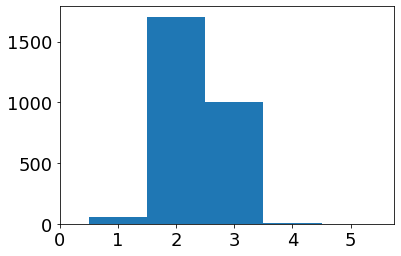

In [33]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(guH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [34]:
csIndx = sorted(list(set(cardShockAllData.index)))
csH = allDataDF.loc[csIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Cardiogenic Shock/Preprocessed Data/CardiogenicShock_AllData.csv")
csH

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,MAP,PP,PPP,PPRatio,Deth,Rhp,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
Z1002839,58.0,1.0,0.0,0.0,NaN,6.0,6.0,0.0,0.0,0.0,...,123.666667,42.0,0.461538,0.451613,1,0,1,5,1,1
Z1002839,58.0,1.0,0.0,0.0,NaN,NaN,6.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,1,0,1,5,1,1
Z1002839,58.0,1.0,0.0,0.0,NaN,NaN,6.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,1,0,1,5,1,1
Z101592,79.0,1.0,0.0,0.0,19.3,6.0,17.0,0.0,0.0,0.0,...,136.000000,46.0,0.460000,0.380165,1,1,1,5,1,1
Z101592,79.0,1.0,0.0,0.0,18.3,3.0,17.0,0.0,0.0,0.0,...,124.666667,38.0,0.422222,0.316667,1,1,1,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z964794,61.0,1.0,0.0,0.0,NaN,5.0,33.0,0.0,0.0,0.0,...,134.666667,33.0,0.351064,0.358696,1,1,1,5,1,1
Z964794,61.0,1.0,0.0,0.0,28.0,13.0,33.0,0.0,0.0,0.0,...,129.000000,34.0,0.373626,0.253731,1,1,4,4,4,2
Z977261,47.0,2.0,0.0,0.0,38.6,7.0,7.0,0.0,0.0,0.0,...,148.666667,57.0,0.508929,0.527778,1,0,1,5,1,1


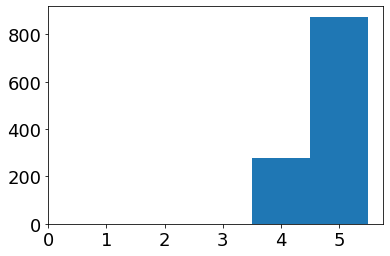

In [35]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(csH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()

In [36]:
csIndx = sorted(list(set(serialAllData.index)))
csH = allDataDF.loc[csIndx,:]

csH = saveClusteredData(csH, scoreAsmts,"Data Validation/Serial Cardiac Caths/Preprocessed Data/SerialCardiac_AllData.csv")
csH

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,MAP,PP,PPP,PPRatio,Deth,Rhp,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
Z103426,49.0,2.0,0.0,0.0,24.2,83.0,83.0,0.0,0.0,0.0,...,143.666667,42.0,0.407767,0.666667,0,0,4,4,4,2
Z103426,49.0,2.0,0.0,0.0,NaN,NaN,83.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0,0,4,4,4,2
Z103426,49.0,2.0,0.0,0.0,NaN,NaN,83.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0,0,1,5,1,1
Z103697,56.0,2.0,0.0,0.0,NaN,12.0,16.0,0.0,0.0,0.0,...,132.333333,29.0,0.318681,0.216418,0,1,4,4,4,2
Z103697,56.0,2.0,0.0,0.0,NaN,4.0,16.0,0.0,0.0,0.0,...,144.666667,28.0,0.285714,0.184211,0,1,4,4,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z958018,55.0,2.0,0.0,0.0,16.1,14.0,30.0,0.0,0.0,0.0,...,151.666667,45.0,0.412844,0.266272,0,1,4,4,4,2
Z958018,55.0,2.0,0.0,0.0,19.1,2.0,30.0,0.0,0.0,0.0,...,117.666667,31.0,0.373494,0.191358,0,1,1,5,1,1
Z98220,46.0,1.0,0.0,0.0,27.1,4.0,16.0,0.0,0.0,0.0,...,187.333333,39.0,0.304688,0.286765,0,1,4,4,4,2


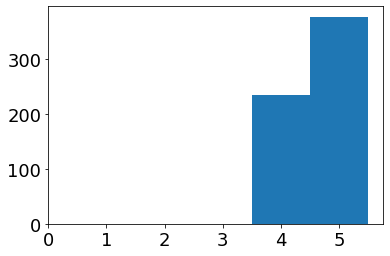

In [37]:
#Look at distribution of scores
scLabs = [1,2,3,4,5,6]
plt.hist(csH['ScoreDeath'], scLabs, align='left')
plt.xticks(range(6))
plt.show()